In [1]:
import yaml
import numpy as np
from TraceSimulator import LongTraceSimulator
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft
from scipy.signal import fftconvolve


def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict

config = read_yaml_to_dict('/home/dwong/DELight_mtr/trigger_study/archive/wk11/config.yaml')
lts = LongTraceSimulator(config)


sampling_frequency = 3906250
vac_template = np.load("templates/vac_ch_template.npy")
template = np.load("templates/sub_ch_template.npy")
noise_psd = np.load("../../templates/noise_psd_from_MMC.npy")
length = len(template)

if length%2==0:
    noise_psd_unfolded = np.concatenate(([np.inf],
                                                noise_psd[1:-1]/2,
                                                [noise_psd[-1]],
                                                noise_psd[-2:0:-1]/2))
else:
    noise_psd_unfolded = np.concatenate(([np.inf],
                                                noise_psd[1:]/2,
                                                noise_psd[-1:0:-1]/2))
    
template_fft = fft(template)/sampling_frequency

kernel_fft = template_fft.conjugate() / noise_psd_unfolded
kernel_normalization = np.real(np.dot(kernel_fft, template_fft))*sampling_frequency/length 
filter_kernel = kernel_fft / kernel_normalization
kernel_td = np.real(ifft(filter_kernel)) * sampling_frequency


In [2]:
trace, idx= lts.generate(
            E=70000,
            x=-94, y=0, z=-1800,
            no_noise=False,
            type_recoil='ER',
            quantize=True,
            phonon_only=False
        )
trace = trace[0]

32768


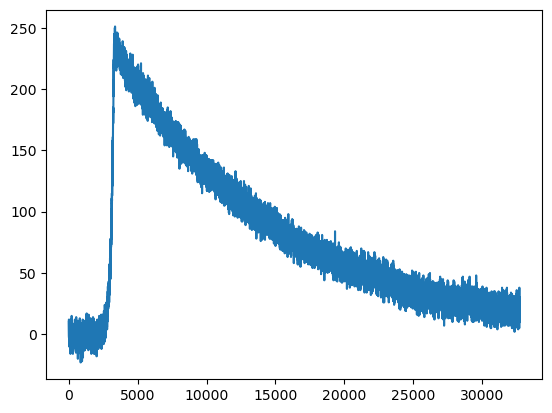

In [3]:
example = trace[7][idx:idx+32768]
print(len(example))
plt.plot(example)

In [4]:
filtered_trace = fftconvolve(trace[7], kernel_td[::-1], mode='valid') / kernel_normalization

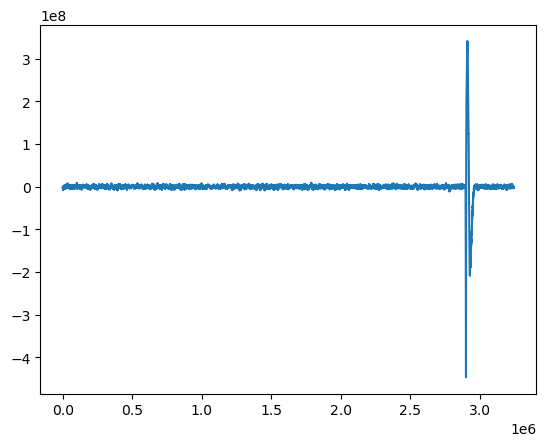

In [9]:
plt.plot(filtered_trace)

In [6]:
t0_relative = np.argmax(filtered_trace)
print(t0_relative-idx)

-16636


In [7]:
L = len(trace[5])
N = len(kernel_td)
conv_len = L + N - 1

# Zero-pad both
trace_padded = np.pad(trace[5], (0, conv_len - L))
kernel_padded = np.pad(kernel_td[::-1], (0, conv_len - N))

# FFT both
trace_fft = fft(trace_padded)
kernel_fft = fft(kernel_padded)

# Multiply in frequency domain
filtered_fft = trace_fft * kernel_fft

# IFFT
filtered_td = np.real(ifft(filtered_fft))

# Normalize
filtered_td /= kernel_normalization

# Optional: trim to valid region
filtered_valid = filtered_td[N-1:L]

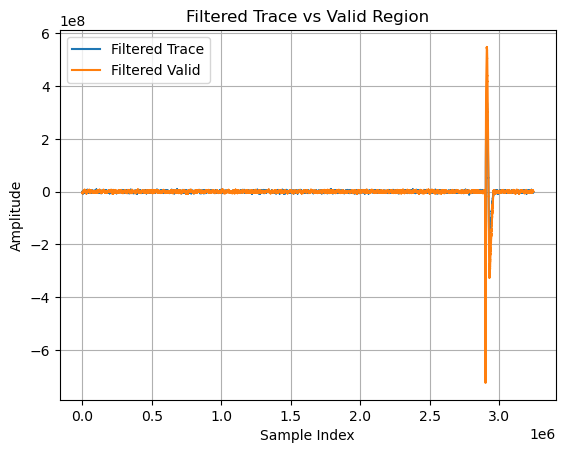

In [10]:
import matplotlib.pyplot as plt

plt.plot(filtered_trace, label='Filtered Trace')
plt.plot(filtered_valid, label='Filtered Valid')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Filtered Trace vs Valid Region')
plt.grid(True)
plt.show()
